In [ ]:
# This notebook requires emcee and corner installed
# If you don't have them, you can install them with:
# pip install -U setuptools setuptools_scm pep517
# pip install -U emcee
# pip install -U corner
# pip install -U tqdm # optional

In [190]:
####
# I planned numerical expriments and examples.
# ChatGPT was used to generate the code. 
####

# Optimisation vs Sampling - Single Gaussian Absorption Line

This minimal example keeps only two free parameters:

* **Continuum level** $C$
* **Equivalent width** $W$ of an absorption Gaussian

with the width $\sigma_\text{line}$ and central wavelength $\lambda_0$ **held fixed**.

---

## Forward model

$$
F(\lambda \mid C, W) \;=\; C \Bigl[\,1 - \frac{W}{\sqrt{2\pi}\,\sigma_\text{line}}\,
            e^{-\frac{(\lambda-\lambda_0)^2}{2\sigma_\text{line}^2}} \Bigr].
$$

The amplitude that multiplies the Gaussian is $A = W / (\sqrt{2\pi}\,\sigma_\text{line})$.

---

## Statistical model

* **Likelihood** — Each pixel has independent Gaussian noise $\sigma_\text{noise}$:

$$
\mathcal{L}(C, W) \;=\; \prod_{i=1}^{N}
  \frac{1}{\sqrt{2\pi}\,\sigma_\text{noise}}\;
  \exp\!\Bigl[-\tfrac12\bigl(\tfrac{d_i - F_i(C,W)}{\sigma_\text{noise}}\bigr)^2\Bigr].
$$

* **Prior** — Uniform within rectangles  

$$
p(C)=\text{U}(0.5,1.5),\qquad
p(W)=\text{U}(0,1).
$$

* **Posterior** from Bayes:

$$
p(C, W \mid d) \;=\;
\frac{\mathcal{L}(C,W)\,p(C)\,p(W)}
     {\int\!\!\int \mathcal{L}\,p(C)\,p(W)\,dC\,dW}.
$$

Taking logs,

$$
\log p(C,W\mid d) = -\frac{1}{2\sigma_\text{noise}^2}
                    \sum_{i}(d_i-F_i)^2
                  + \log p(C) + \log p(W) + \text{const}.
$$

Below we **visualise** this log‑posterior on a $(C,\,W)$ grid,
run an optimiser, and finally explore it with MCMC.

In [191]:
# --- Adjustable global parameters ------------------------------------------------
SNR = 5           # try 10, 30, 100 …

# --- Imports ---------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import emcee, corner
from matplotlib.patches import Ellipse
np.random.seed(1234)

In [192]:
# --- Constants & synthetic data --------------------------------------------------
sigma_line = 0.5          # nm
lambda0     = 500.0        # nm

C_true = 1.0
W_true = 0.5               # nm

min_wavelength = 497.0
max_wavelength = 503.0
no_fluxes = 100

def gaussian(lam, amp, mu, sigma):
    return amp * np.exp(-0.5*(lam-mu)**2/sigma**2)

def model_flux(lam, C, W):
    amp = W / (np.sqrt(2*np.pi)*sigma_line)
    return C * (1 - gaussian(lam, amp, lambda0, sigma_line))

# wavelength grid and noise
lam = np.linspace(min_wavelength, max_wavelength, no_fluxes)
flux_clean = model_flux(lam, C_true, W_true)
noise_std  = flux_clean.mean() / SNR
flux = flux_clean + np.random.normal(0, noise_std, lam.size)

print(f'Synthetic spectrum generated with S/N ≈ {SNR}')


Synthetic spectrum generated with S/N ≈ 5


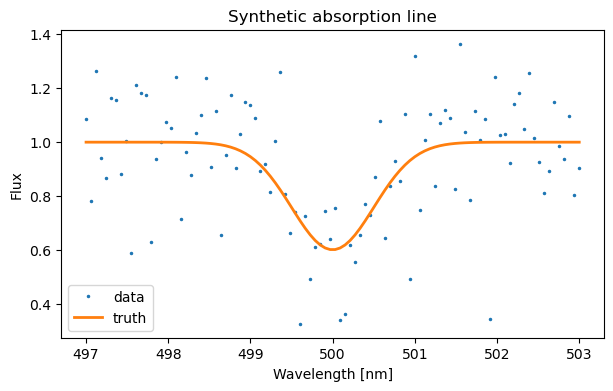

In [193]:
# Quick look at data
plt.figure(figsize=(7,4))
plt.plot(lam, flux, '.', ms=3, label='data')
plt.plot(lam, flux_clean, '-', lw=2, label='truth')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux')
plt.legend()
plt.title('Synthetic absorption line')
plt.show()


In [194]:
# --- Compute log‑posterior grid --------------------------------------------------
C_grid = np.linspace(0.8, 1.2, 120)
W_grid = np.linspace(0.2, 0.8, 120)
logpost = np.empty((C_grid.size, W_grid.size))

def log_likelihood(C, W):
    model = model_flux(lam, C, W)
    return -0.5*np.sum((flux - model)**2)/noise_std**2

for i,C in enumerate(C_grid):
    for j,W in enumerate(W_grid):
        lp = 0 if (0.5 < C < 1.5 and 0 < W < 1) else -np.inf
        logpost[i,j] = lp + log_likelihood(C,W)

logpost -= logpost.max()


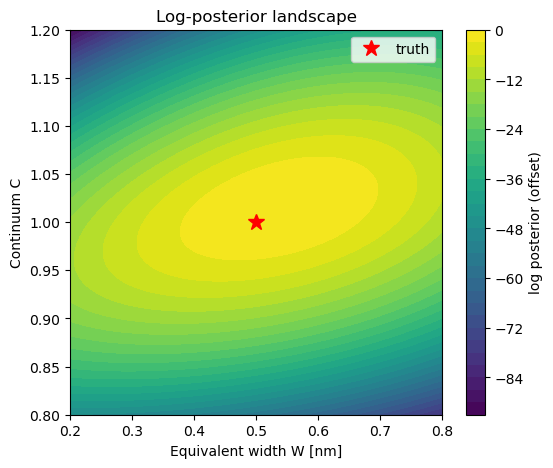

In [195]:
plt.figure(figsize=(6,5))
cs = plt.contourf(W_grid, C_grid, logpost, levels=30, cmap='viridis')
plt.colorbar(cs, label='log posterior (offset)')
plt.plot(W_true, C_true, 'r*', ms=12, label='truth')
plt.xlabel('Equivalent width W [nm]')
plt.ylabel('Continuum C')
plt.title('Log‑posterior landscape')
plt.legend()
plt.show()

In [196]:
# --- Optimisation ---------------------------------------------------------------
def residuals(theta):
    C, W = theta
    model = model_flux(lam, C, W)
    return (flux - model) / noise_std

theta0 = [0.9, 0.3]
opt = least_squares(residuals, theta0, bounds=([0.5,0.0],[1.5,1.0]))
C_opt, W_opt = opt.x
print(f'Optimiser result: C={C_opt:.3f}, W={W_opt:.3f}')

# Covariance from Jacobian
J = opt.jac
cov = np.linalg.inv(J.T @ J)
print("Covariance matrix:")
print(cov)


Optimiser result: C=1.014, W=0.540
Covariance matrix:
[[0.0004759  0.00057814]
 [0.00057814 0.00421781]]


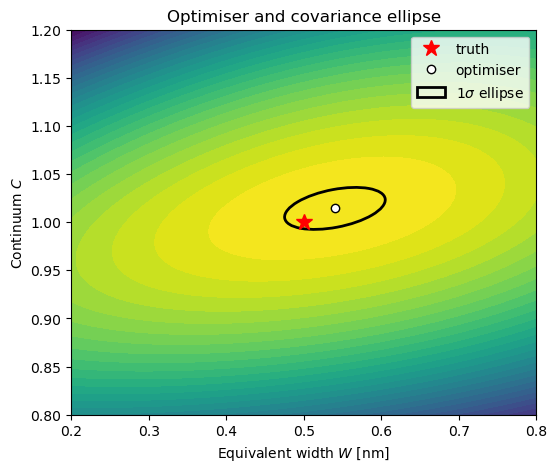

In [197]:
# --- Error ellipse on posterior --------------------------------------------------
vals, vecs = np.linalg.eigh(cov)       # cov is in (C, W) order
order = vals.argsort()[::-1]           # sort by descending eigen-value
vals, vecs = vals[order], vecs[:, order]

# vecs[:, 0] = [v_C, v_W];  x-axis is W, so swap:
vx, vy = vecs[1, 0], vecs[0, 0]        # (x, y) in plotting coordinates
theta = np.degrees(np.arctan2(vy, vx))

w, h = 2 * np.sqrt(vals)               # diameters for the 1-σ contour

fig, ax = plt.subplots(figsize=(6, 5))
ax.contourf(W_grid, C_grid, logpost, levels=30, cmap='viridis')
ax.plot(W_true, C_true, 'r*', ms=12, label='truth')
ax.plot(W_opt, C_opt, 'wo', ms=6, mec='k', label='optimiser')

ell = Ellipse(
    xy=(W_opt, C_opt),
    width=w,
    height=h,
    angle=theta,
    edgecolor='k',
    facecolor='none',
    lw=2,
    label=r'1$\sigma$ ellipse'
)
ax.add_patch(ell)
ax.set_xlabel('Equivalent width $W$ [nm]')
ax.set_ylabel('Continuum $C$')
ax.set_title('Optimiser and covariance ellipse')
ax.legend()
plt.show()


In [198]:
# --- MCMC sampling --------------------------------------------------------------
def log_prior(theta):
    C, W = theta
    if 0.5 < C < 1.5 and 0 < W < 1:
        return 0.0
    return -np.inf

def log_prob(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(*theta)

ndim, nwalkers = 2, 20
p0 = opt.x + 1e-3 * np.random.randn(nwalkers, ndim) + np.array([0.3, 0.3]) # a little kick to show the burn-in phase

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(p0, 4000, progress=True)
samples = sampler.get_chain()
flat = sampler.get_chain(discard=200, thin=10, flat=True)
print('Posterior sample shape:', flat.shape)


100%|██████████| 4000/4000 [00:03<00:00, 1202.07it/s]

Posterior sample shape: (7600, 2)


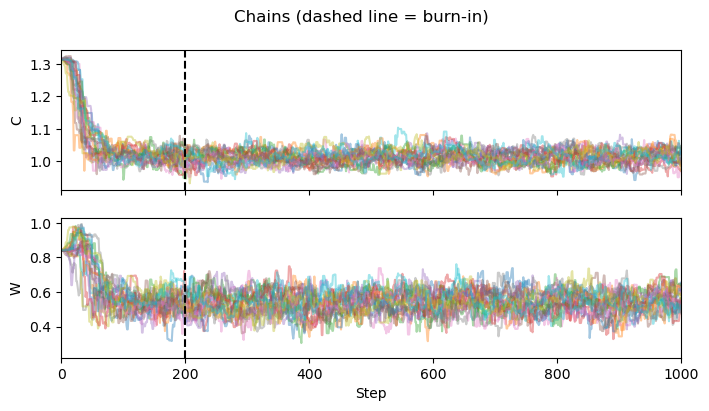

In [199]:
# --- Chain trace plot ------------------------------------------------------------
fig, axes = plt.subplots(2,1, figsize=(8,4), sharex=True)
labels = ['C','W']
for i in range(2):
    axes[i].plot(samples[:,:,i], alpha=0.4)
    axes[i].axvline(200, color='k', ls='--')
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel('Step')
axes[0].set_xlim(0, 1000) # zoom in to see burn-in
fig.suptitle('Chains (dashed line = burn‑in)')
plt.show()


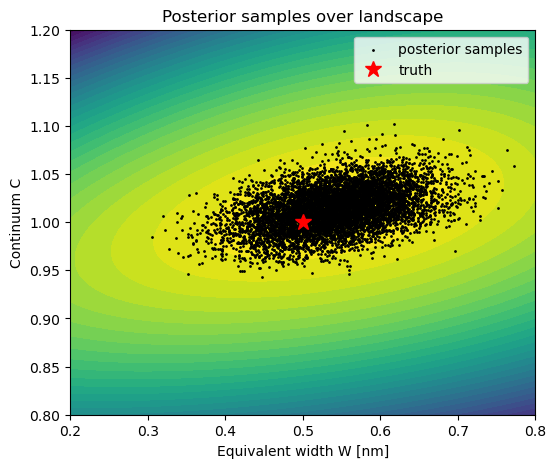

In [200]:
# --- Samples on posterior --------------------------------------------------------
plt.figure(figsize=(6,5))
cs = plt.contourf(W_grid, C_grid, logpost, levels=30, cmap='viridis')
plt.scatter(flat[:,1], flat[:,0], s=1, c='k', alpha=1.0, label='posterior samples')
plt.plot(W_true, C_true, 'r*', ms=12, label='truth')
plt.xlabel('Equivalent width W [nm]')
plt.ylabel('Continuum C')
plt.title('Posterior samples over landscape')
plt.legend()
plt.show()


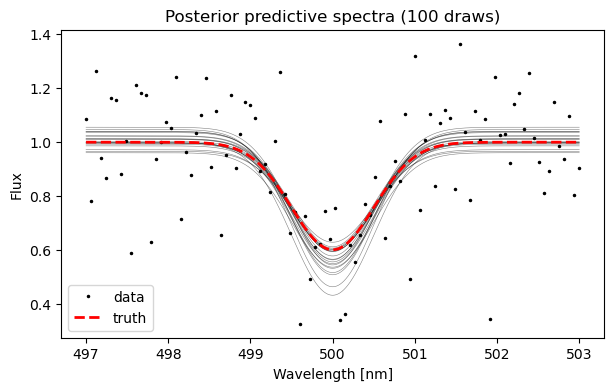

In [201]:
# --- Posterior predictive draws --------------------------------------------------
plt.figure(figsize=(7,4))
plt.plot(lam, flux, '.', ms=3, color='k', label='data')
idx = np.random.choice(flat.shape[0], 20, replace=False)

lam_more = np.linspace(min_wavelength, max_wavelength, 10 * no_fluxes)
for C_s, W_s in flat[idx]:
    plt.plot(lam_more, model_flux(lam_more, C_s, W_s), lw=0.4, alpha=0.5, color='k')
plt.plot(lam_more, model_flux(lam_more, C_true, W_true), 'r--', lw=2, label='truth')

plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux')
plt.title('Posterior predictive spectra (100 draws)')
plt.legend()
plt.show()


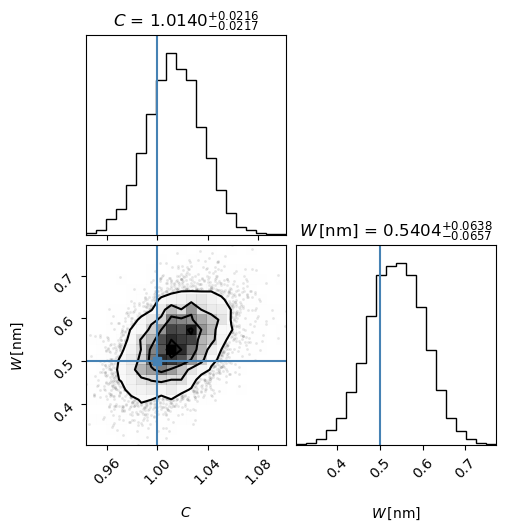

C  : 1.0140  (+0.0216/-0.0217)
W  : 0.5404  (+0.0638/-0.0657)


In [202]:
# --- Corner plot + parameter summaries ------------------------------------------
import corner
import numpy as np

# `flat` holds the MCMC samples with columns [C, W] (after burn-in & thinning)

labels   = [r"$C$", r"$W\,[\mathrm{nm}]$"]
truths   = [C_true, W_true]

fig = corner.corner(
    flat,
    labels=labels,
    truths=truths,
    show_titles=True,
    title_fmt=".4f",
    title_kwargs={"fontsize": 12}
)

# Save or display as you like
plt.show()

# --- Print median and 1-σ credible intervals ------------------------------------
quantiles = [16, 50, 84]
C_q, W_q = np.percentile(flat, quantiles, axis=0).T

print(f"C  : {C_q[1]:.4f}  (+{C_q[2]-C_q[1]:.4f}/-{C_q[1]-C_q[0]:.4f})")
print(f"W  : {W_q[1]:.4f}  (+{W_q[2]-W_q[1]:.4f}/-{W_q[1]-W_q[0]:.4f})")


### Check MCMC results against quadratic approximation from fitting

Optimiser (quadratic) vs   MCMC Gaussian fit
---------------------------------------------------------------
C  : 1.0144 ± 0.0218      1.0140 ± 0.0218
W  : 0.5402 ± 0.0649      0.5397 ± 0.0653

Optimiser-cov off-diag:  0.0005781386657464348
MCMC-cov     off-diag:  0.0005915016127406636


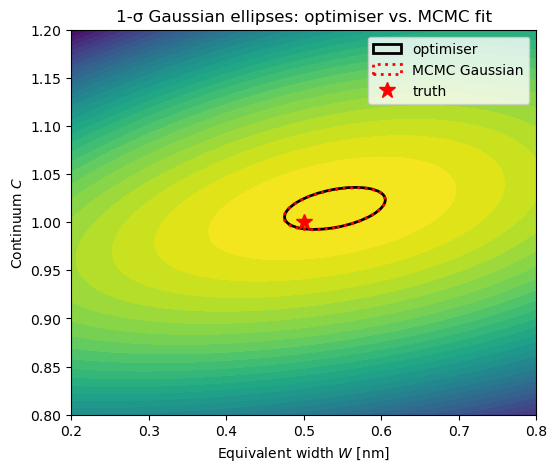

In [203]:
# -------------------------------------------------------------------
# 1. Fit a Gaussian (mean & covariance) to the MCMC posterior samples
#    and compare with the optimiser’s quadratic approximation
# -------------------------------------------------------------------

# flat[:, 0] = C samples,  flat[:, 1] = W samples
mu_mc   = flat.mean(axis=0)                    # [C̄, W̄]
cov_mc  = np.cov(flat, rowvar=False)           # 2×2 covariance matrix

# --- Print side-by-side summaries -----------------------------------
print("Optimiser (quadratic) vs   MCMC Gaussian fit")
print("---------------------------------------------------------------")
print(f"C  : {C_opt:.4f} ± {np.sqrt(cov[0,0]):.4f}      "
      f"{mu_mc[0]:.4f} ± {np.sqrt(cov_mc[0,0]):.4f}")
print(f"W  : {W_opt:.4f} ± {np.sqrt(cov[1,1]):.4f}      "
      f"{mu_mc[1]:.4f} ± {np.sqrt(cov_mc[1,1]):.4f}")
print("\nOptimiser-cov off-diag: ", cov[0,1])
print("MCMC-cov     off-diag: ", cov_mc[0,1])

# -------------------------------------------------------------------
# 2. Plot both 1-σ ellipses on the posterior landscape
# -------------------------------------------------------------------
def ellipse_from_cov(center, cov, **kwargs):
    """Return a matplotlib Ellipse for a given 2-D covariance."""
    vals, vecs = np.linalg.eigh(cov)
    order      = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Convert eigen-vector from (C,W) ordering -> plotting (W,C)
    vx, vy = vecs[1, 0], vecs[0, 0]            # swap!
    theta  = np.degrees(np.arctan2(vy, vx))

    width, height = 2 * np.sqrt(vals)          # 1-σ diameters
    return Ellipse(
        xy=center[::-1],                       # (W,C) for plotting
        width=width,
        height=height,
        angle=theta,
        facecolor="none",
        **kwargs,
    )

fig, ax = plt.subplots(figsize=(6, 5))
ax.contourf(W_grid, C_grid, logpost, levels=30, cmap="viridis")

# optimiser ellipse (black)
ax.add_patch(
    ellipse_from_cov((C_opt, W_opt), cov, edgecolor="k", lw=2, label="optimiser", ls="-")
)
# MCMC Gaussian ellipse (red)
ax.add_patch(
    ellipse_from_cov(mu_mc, cov_mc, edgecolor="red", lw=2, label="MCMC Gaussian", ls=":")
)

ax.plot(W_true, C_true, "r*", ms=12, label="truth")
ax.set_xlabel("Equivalent width $W$ [nm]")
ax.set_ylabel("Continuum $C$")
ax.set_title("1-σ Gaussian ellipses: optimiser vs. MCMC fit")
ax.legend()
plt.show()


### Short example when the results are not the same...

Observed K = 0.783 ± 0.2


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:05<00:00, 1772.21it/s]


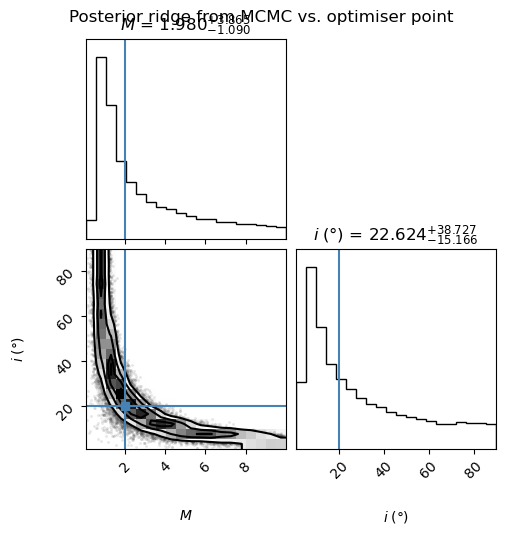

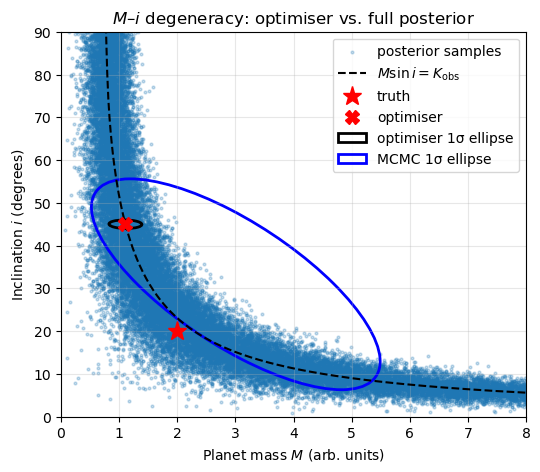


Parameter estimates (±1σ)
Optimiser : M = 1.108 ± 0.283   i = 45.00° ± 1.00°
MCMC      : M = 3.007 ± 2.483   i = 30.96° ± 24.65°


In [204]:
# ================================================================
# Nearly perfect degeneracy: planet mass M vs. orbital inclination i
# Data: a single radial-velocity semi-amplitude measurement K_obs
# Model: circular orbit, so K_model = M * sin(i)
# Goal: contrast optimiser’s local Gaussian with full MCMC posterior
# ================================================================

import numpy as np, matplotlib.pyplot as plt, emcee, corner
from scipy.optimize import minimize
from matplotlib.patches import Ellipse
np.random.seed(42)

# ----------------------------------------------------------------
# 1.  Truth + synthetic data
# ----------------------------------------------------------------
M_true  = 2.0            # “Jupiter masses” (arbitrary units)
i_true  = 20.0           # degrees
sigma_K = 0.2            # observational error on K
K_obs   = M_true * np.sin(np.deg2rad(i_true)) + np.random.normal(0, sigma_K)

print(f"Observed K = {K_obs:.3f} ± {sigma_K}")

# ----------------------------------------------------------------
# 2.  Log-posterior (uniform priors)
# ----------------------------------------------------------------
def log_prob(theta):
    M, inc = theta            # inc in degrees
    if 0.0 < M < 10.0 and 0.0 < inc < 90.0:       # flat box priors
        K_model = M * np.sin(np.deg2rad(inc))
        return -0.5 * ((K_obs - K_model)/sigma_K)**2
    return -np.inf

# ----------------------------------------------------------------
# 3.  Optimisation
# ----------------------------------------------------------------
opt = minimize(lambda t: -log_prob(t), [1.0, 45.0])
M_opt, i_opt = opt.x
cov_opt      = opt.hess_inv.todense() if hasattr(opt.hess_inv, "todense") else opt.hess_inv
cov_opt      = np.asarray(cov_opt)      # 2×2 covariance from quadratic fit

# ----------------------------------------------------------------
# 4.  MCMC sampling
# ----------------------------------------------------------------
ndim, nwalk = 2, 40
p0   = opt.x + 1e-3 * np.random.randn(nwalk, ndim)
sampler = emcee.EnsembleSampler(nwalk, ndim, log_prob)
sampler.run_mcmc(p0, 10000, progress=True)
flat  = sampler.get_chain(discard=1000, thin=10, flat=True)

# posterior mean & covariance
mu_mc  = flat.mean(axis=0)
cov_mc = np.cov(flat, rowvar=False)

# ----------------------------------------------------------------
# 5.  Corner plot
# ----------------------------------------------------------------
corner.corner(
    flat,
    labels=[r"$M$", r"$i\;(°)$"],
    truths=[M_true, i_true],
    show_titles=True,
    title_fmt=".3f"
)
plt.suptitle("Posterior ridge from MCMC vs. optimiser point")
plt.show()

# ----------------------------------------------------------------
# 6.  Helper to build 1-σ ellipse from covariance
# ----------------------------------------------------------------
def ellipse_from_cov(center, cov, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order      = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * np.sqrt(vals)                 # diameters (1-σ)
    theta = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    return Ellipse(xy=center, width=width, height=height, angle=theta, **kwargs)

# ----------------------------------------------------------------
# 7.  2-D plot with both ellipses
# ----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

# samples & constant-K curve
ax.scatter(flat[:,0], flat[:,1], s=4, alpha=0.25, label="posterior samples")
M_line = np.linspace(0.1, 10, 500)
ax.plot(M_line, np.degrees(np.arcsin(np.clip(K_obs / M_line, 0, 1))),
        "k--", lw=1.5, label=r"$M\sin i = K_{\mathrm{obs}}$")

# truth and optimiser
ax.plot(M_true, i_true, "r*", ms=14, label="truth")
ax.plot(M_opt , i_opt , "rX", ms=10, label="optimiser")

# ellipses
ax.add_patch(ellipse_from_cov((M_opt, i_opt), cov_opt,
                              edgecolor="black", facecolor="none", lw=2,
                              label="optimiser 1σ ellipse"))
ax.add_patch(ellipse_from_cov(mu_mc, cov_mc,
                              edgecolor="blue", facecolor="none", lw=2,
                              label="MCMC 1σ ellipse"))

# cosmetics
ax.set_xlim(0, 8.0); ax.set_ylim(0, 90)
ax.set_xlabel(r"Planet mass $M$ (arb. units)")
ax.set_ylabel(r"Inclination $i$ (degrees)")
ax.set_title(r"$M$–$i$ degeneracy: optimiser vs. full posterior")
ax.legend(loc="upper right"); ax.grid(alpha=0.3)
plt.show()

# ----------------------------------------------------------------
# 8.  Numeric summaries
# ----------------------------------------------------------------
def summary(name, mu, cov):
    err = np.sqrt(np.diag(cov))
    print(f"{name:10s}: M = {mu[0]:.3f} ± {err[0]:.3f}   "
          f"i = {mu[1]:.2f}° ± {err[1]:.2f}°")

print("\nParameter estimates (±1σ)")
summary("Optimiser", np.array([M_opt, i_opt]), cov_opt)
summary("MCMC",      mu_mc,                     cov_mc)
